# Experimental Model Mark II: sktime

For reference: baseline sktime forest classifier (copied from the corresponding notebook)

f1-score \[0.78655 0.77342 0.68837 0.71134\] average 0.73992 (on TS set)  
f1-score \[0.72778 0.67456 0.60145 0.53684\] average 0.63516 (600 => 0.64042, 700 => 0.64141, 800 => 0.68631) (on TSNV set)  

### Imports and reading the dataset

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int)
    return X, Y

dataset = pd.read_pickle('../Dataset/experimental_dataset_tsnv_24.gz')
# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 5633; Dev set size: 626; Testing set size: 696


### Data Prepping

In [3]:
PAST_TRACK_LIMIT = 24

def convert_X(dataset_X):
    '''Takes in a (n_samples, n_features) Pandas dataframe and returns it in shape (n_samples, n_features, time_series_length)'''
    to_drop = ["DVMAX{0:02d}".format(i) for i in range(0, PAST_TRACK_LIMIT, 6)]
    print("dropping", to_drop)
    dataset_X = dataset_X.drop(to_drop, axis=1)
    
    processed_samples = 0
    new_dataset = []
    for index, row in dataset_X.iterrows():
        new_row = []

        # obtain time series for each feature        
        for i in range(29):
            feature_name = dataset_X.columns[i][:-2]
            feature_series = []
            for j in range(0, PAST_TRACK_LIMIT+6, 6):        
                feature_series.append(row.loc["{0}{1:02d}".format(feature_name, j)]) # access by column name
            feature_series.reverse() # newest data come last
            feature_series = pd.Series(data=feature_series) # correct type for each cell
            new_row.append(feature_series)

        # new_row = pd.Series(data=new_row, index=new_features)
        new_dataset.append(new_row)
        processed_samples += 1

        if processed_samples % 100 == 0:
            print("Finished concatenating {0}/{1} samples...".format(processed_samples, dataset_X.shape[0]))

    # get new column names
    new_features = []
    for i in range(10):
            feature_name = dataset_X.columns[i][:-2]
            new_features.append(feature_name)
            
    # convert types back
    # converted_X = pd.DataFrame(new_dataset, columns=new_features)
    converted_X = np.array(new_dataset)
    print("Completed")
    return converted_X

train_X = convert_X(train_X)
dev_X = convert_X(dev_X)

dropping ['DVMAX00', 'DVMAX06', 'DVMAX12', 'DVMAX18']
Finished concatenating 100/5633 samples...
Finished concatenating 200/5633 samples...
Finished concatenating 300/5633 samples...
Finished concatenating 400/5633 samples...
Finished concatenating 500/5633 samples...
Finished concatenating 600/5633 samples...
Finished concatenating 700/5633 samples...
Finished concatenating 800/5633 samples...
Finished concatenating 900/5633 samples...
Finished concatenating 1000/5633 samples...
Finished concatenating 1100/5633 samples...
Finished concatenating 1200/5633 samples...
Finished concatenating 1300/5633 samples...
Finished concatenating 1400/5633 samples...
Finished concatenating 1500/5633 samples...
Finished concatenating 1600/5633 samples...
Finished concatenating 1700/5633 samples...
Finished concatenating 1800/5633 samples...
Finished concatenating 1900/5633 samples...
Finished concatenating 2000/5633 samples...
Finished concatenating 2100/5633 samples...
Finished concatenating 2200/563

In [4]:
from sktime.transformations.panel.compose import ColumnConcatenator

print("Before transform:", train_X.shape)
concat_train_X = ColumnConcatenator().fit_transform(train_X)
concat_dev_X = ColumnConcatenator().fit_transform(dev_X)
print("After transform:", concat_train_X.shape)
print("Each element is:", concat_train_X.iloc[0].iloc[0].shape)

Before transform: (5633, 29, 5)
After transform: (5633, 1)
Each element is: (145,)


In [5]:
# problem checking
X = np.asanyarray(concat_train_X)
if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum()) and not np.isfinite(X).all()):
    raise

for i in range(5633):
    if concat_train_X.iloc[i].iloc[0].isnull().values.any():
        print(i)
    if np.isinf(concat_train_X.iloc[i].iloc[0]).values.sum() > 0:
        print(i)    

### Tools

In [6]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/experimental_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)

In [7]:
#### FOR CLASSIFIERS
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report

# convert predict_proba outputs of (n_targets, n_samples, 2) to (n_samples, n_classes)
def get_multioutput_proba(preds):
    '''Takes in a list of shape (n_targets, n_samples, 2) and converts it to np.array with shape (n_samples, n_targets)'''
    preds = np.array(preds)
    new_preds = []
    for i in range(4):
        new_preds.append(preds[i,:,1])
    new_preds = np.array(new_preds).T
    return new_preds

# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    if isinstance(clf, MultiOutputClassifier):
        all_preds = get_multioutput_proba(all_preds)
    best_thresholds = []
    best_f1_scores = []
    n_classes = 4
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    if isinstance(clf, MultiOutputClassifier):
        preds_probs = get_multioutput_proba(preds_probs)
    n_classes = 4
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [20]:
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [22]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

def calibration_plot(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y;
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")  
    all_preds = np.array(clf.predict_proba(dataset_X)) if not isinstance(clf, MultiOutputRegressor) else clf.predict(dataset_X)
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = all_preds
    preds = preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = all_preds
    preds = preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

### Time Series Forest Classifier

Without additional hyperparameters: f1-score \[0.89831 0.94872 0.85714 0.78788\] average 0.87301  
min_interval = 5, n_estimators = 250: f1-score \[0.88889 0.92500 0.89474 0.83333\] average 0.88549  
min_interval = 5, n_estimators = 275: f1-score \[0.88696 0.92308 0.89474 0.83333\] average 0.88453  
min_interval = 5, n_estimators = 300: f1-score \[0.89256 0.93506 0.89474 0.83333\] average **0.88892**

Maybe calibration is going to be useful.

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Best Threshold=0.40333, F-Score=0.90164
Best Threshold=0.39000, F-Score=0.96203
Best Threshold=0.28000, F-Score=0.92308
Best Threshold=0.16667, F-Score=0.86486


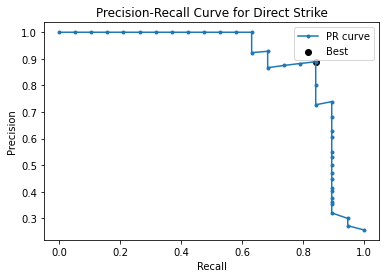

In [9]:
from sktime.classification.interval_based import TimeSeriesForestClassifier

tsfs_clf = TimeSeriesForestClassifier(min_interval=5, n_estimators=300, n_jobs=-1, random_state=42)
tsfs_clf = MultiOutputClassifier(tsfs_clf, n_jobs=-1).fit(concat_train_X, train_Y)
best_thresholds, best_f1_scores = optimize_thresholds(tsfs_clf, concat_dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.025797
Class 1, no calibration: 0.015523
Class 2, no calibration: 0.011284
Class 3, no calibration: 0.015081


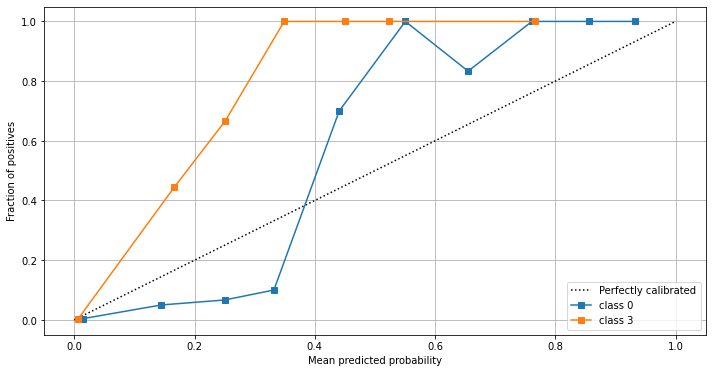

In [10]:
calibration_plot(tsfs_clf, concat_dev_X, dev_Y)

In [11]:
preds = predictions_with_thresholds(tsfs_clf, best_thresholds, concat_dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.90000   0.88525   0.89256        61
           1    0.94737   0.92308   0.93506        39
           2    0.94444   0.85000   0.89474        20
           3    0.88235   0.78947   0.83333        19

   micro avg    0.91729   0.87770   0.89706       139
   macro avg    0.91854   0.86195   0.88892       139
weighted avg    0.91727   0.87770   0.89670       139
 samples avg    0.08879   0.08866   0.08744       139



In [12]:
save_sklearn_model_to_file(tsfs_clf, "gscv_tsfs_clf")

### Optimization

min_interval: best value in 1-9 is 5  
n_estimators: best value in 100-600 is 250-275  

In [58]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

tsfs_clf = MultiOutputClassifier(TimeSeriesForestClassifier(n_jobs=-1, random_state=42, min_interval=5), n_jobs=-1)

params_grid = { "estimator__n_estimators":[200, 250, 275, 300] }

scorer = make_scorer(f1_score, zero_division=0, average='macro')

gscv = GridSearchCV(tsfs_clf, params_grid, scoring=scorer, n_jobs=-1, refit=False, cv=3, verbose=4, error_score=0.0).fit(concat_train_X, train_Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.0. Details: 
Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2131, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2140, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/tes

In [59]:
gscv.cv_results_

{'mean_fit_time': array([166.11474721, 189.70006013, 176.71016391, 141.27492817]),
 'std_fit_time': array([ 2.27585846,  0.37472328, 27.35980215,  2.11158562]),
 'mean_score_time': array([28.61274846, 34.1714081 , 44.75197498, 33.76957877]),
 'std_score_time': array([ 2.2249899 , 22.70254061, 12.37075785,  0.4822109 ]),
 'param_estimator__n_estimators': masked_array(data=[200, 250, 275, 300],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__n_estimators': 200},
  {'estimator__n_estimators': 250},
  {'estimator__n_estimators': 275},
  {'estimator__n_estimators': 300}],
 'split0_test_score': array([0.        , 0.        , 0.60794502, 0.62723191]),
 'split1_test_score': array([0.51114354, 0.51847439, 0.52501886, 0.50403029]),
 'split2_test_score': array([0.56128731, 0.55705681, 0.56273863, 0.56696117]),
 'mean_test_score': array([0.35747695, 0.3585104 , 0.56523417, 0.56607446]),
 'std_test_score': array([0.253601

[CV 2/4] END .......estimator__n_estimators=250;, score=0.559 total time= 4.1min
[CV 3/4] END .......estimator__n_estimators=300;, score=0.518 total time= 4.0min
[CV 2/3] END .......estimator__n_estimators=275;, score=0.525 total time= 4.0min
[CV 2/3] END .......estimator__n_estimators=250;, score=0.518 total time= 4.0min
[CV 3/4] END .......estimator__n_estimators=200;, score=0.495 total time= 3.6min
[CV 1/4] END .......estimator__n_estimators=300;, score=0.650 total time= 4.4min
[CV 1/3] END .......estimator__n_estimators=275;, score=0.608 total time= 4.1min
[CV 3/3] END .......estimator__n_estimators=250;, score=0.557 total time= 4.0min
[CV 3/4] END .......estimator__n_estimators=250;, score=0.499 total time= 4.1min
[CV 2/4] END .......estimator__n_estimators=300;, score=0.000 total time= 3.6min
[CV 3/3] END .......estimator__n_estimators=200;, score=0.000 total time= 2.8min
[CV 3/3] END .......estimator__n_estimators=275;, score=0.000 total time=   1.9s
[CV 1/3] END .......estimato

In [51]:
gscv.best_params_

{'estimator__n_estimators': 300}

### Probability Calibration

It is quite uncanny to see how the calibrated classifier always gives silly plots regardless of dataset size. The fact that there are very few class 3 positives should be the culprit. Once again, it is probably ok to feign negligence (?) about calibration.

In [16]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

# base estimator
tsfs_clf = TimeSeriesForestClassifier(min_interval=5, n_estimators=300, n_jobs=-1, random_state=42)
tsfs_clf = OneVsRestClassifier(tsfs_clf, n_jobs=-1)
# calibrated estimator
tsfs_clf = CalibratedClassifierCV(base_estimator=tsfs_clf, cv=7, n_jobs=1, ensemble=False)
tsfs_clf = MultiOutputClassifier(tsfs_clf, n_jobs=-1).fit(concat_train_X, train_Y)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Class 0, no calibration: 0.017984
Class 1, no calibration: 0.006627
Class 2, no calibration: 0.006083
Class 3, no calibration: 0.010362


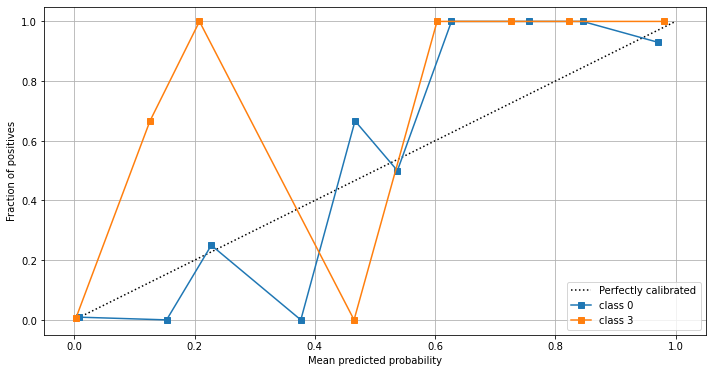

In [17]:
calibration_plot(tsfs_clf, concat_dev_X, dev_Y)

Best Threshold=0.43445, F-Score=0.90164
Best Threshold=0.51001, F-Score=0.96203
Best Threshold=0.28229, F-Score=0.92308
Best Threshold=0.08528, F-Score=0.86486
              precision    recall  f1-score   support

           0    0.90000   0.88525   0.89256        61
           1    0.94737   0.92308   0.93506        39
           2    0.94444   0.85000   0.89474        20
           3    0.88235   0.78947   0.83333        19

   micro avg    0.91729   0.87770   0.89706       139
   macro avg    0.91854   0.86195   0.88892       139
weighted avg    0.91727   0.87770   0.89670       139
 samples avg    0.08879   0.08866   0.08744       139



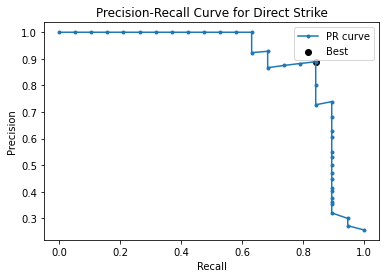

In [18]:
best_thresholds, best_f1_scores = optimize_thresholds(tsfs_clf, concat_dev_X, dev_Y)
preds = predictions_with_thresholds(tsfs_clf, best_thresholds, concat_dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

In [19]:
save_sklearn_model_to_file(tsfs_clf, "calibrated_gscv_tsfs_clf")

### Time Series Forest Regressor
speedrun the refitting...

In [16]:
from sklearn.multioutput import MultiOutputRegressor
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve

param_grid = {"estimator__n_estimators": [350, 400, 450, 500, 550]}

estimator = MultiOutputRegressor(TimeSeriesForestRegressor(
    min_interval=5, n_jobs=-1, random_state=42
), n_jobs=-1)

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')

scorer = make_scorer(my_scorer)

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, verbose=4, cv=3, n_jobs=-1, refit=False).fit(concat_train_X, train_Y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

[CV 1/3] END .......estimator__n_estimators=450;, score=0.768 total time= 5.8min


In [17]:
gscv.cv_results_

{'mean_fit_time': array([209.49007106, 242.16415445, 264.52874438, 273.94881797,
        282.36342573]),
 'std_fit_time': array([1.40428796, 2.26708176, 9.11084326, 2.24346883, 7.46029919]),
 'mean_score_time': array([56.0949142 , 65.76582336, 70.31834904, 65.84638357, 53.85932541]),
 'std_score_time': array([0.68018319, 0.31119876, 4.78062816, 3.5595566 , 6.28189376]),
 'param_estimator__n_estimators': masked_array(data=[350, 400, 450, 500, 550],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__n_estimators': 350},
  {'estimator__n_estimators': 400},
  {'estimator__n_estimators': 450},
  {'estimator__n_estimators': 500},
  {'estimator__n_estimators': 550}],
 'split0_test_score': array([0.76404686, 0.76210885, 0.76815627, 0.76534395, 0.75456486]),
 'split1_test_score': array([0.74634009, 0.75502439, 0.76282481, 0.75129518, 0.75184697]),
 'split2_test_score': array([0.71224643, 0.71032564, 0.7138802 , 0.

In [18]:
gscv.best_params_

{'estimator__n_estimators': 450}

Best Threshold=0.48222, F-Score=0.87719
Best Threshold=0.33778, F-Score=0.93827
Best Threshold=0.21778, F-Score=0.92308
Best Threshold=0.10667, F-Score=0.80952
              precision    recall  f1-score   support

           0    0.94231   0.80328   0.86726        61
           1    0.90244   0.94872   0.92500        39
           2    0.94444   0.85000   0.89474        20
           3    0.72727   0.84211   0.78049        19

   micro avg    0.89474   0.85612   0.87500       139
   macro avg    0.87912   0.86103   0.86687       139
weighted avg    0.90204   0.85612   0.87555       139
 samples avg    0.08280   0.08387   0.08178       139

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.027801
Class 1, no calibration: 0.017232
Class 2, no calibration: 0.012761
Class 3, no calibration: 0.016178


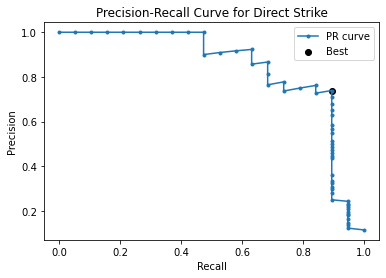

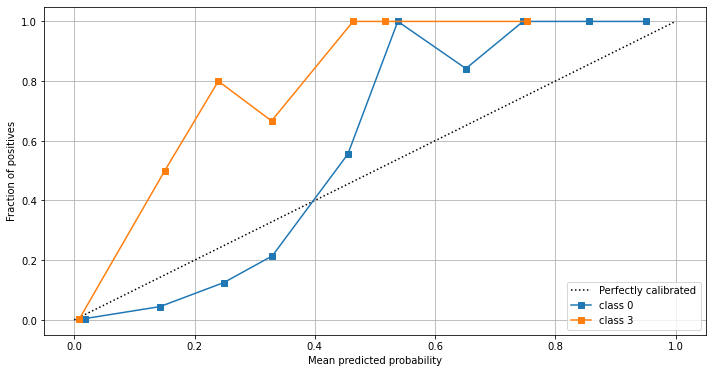

In [23]:
tsfs_regr = MultiOutputRegressor(TimeSeriesForestRegressor(
    n_estimators=450, min_interval=5, n_jobs=-1, random_state=42
), n_jobs=-1).fit(concat_train_X, train_Y)

best_thresholds, best_f1_scores = regressor_find_thresholds(tsfs_regr, concat_dev_X, dev_Y)

preds = regression_label(tsfs_regr, concat_dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

calibration_plot(tsfs_regr, concat_dev_X, dev_Y)

In [24]:
save_sklearn_model_to_file(tsfs_regr, "gscv_tsfs_regr")